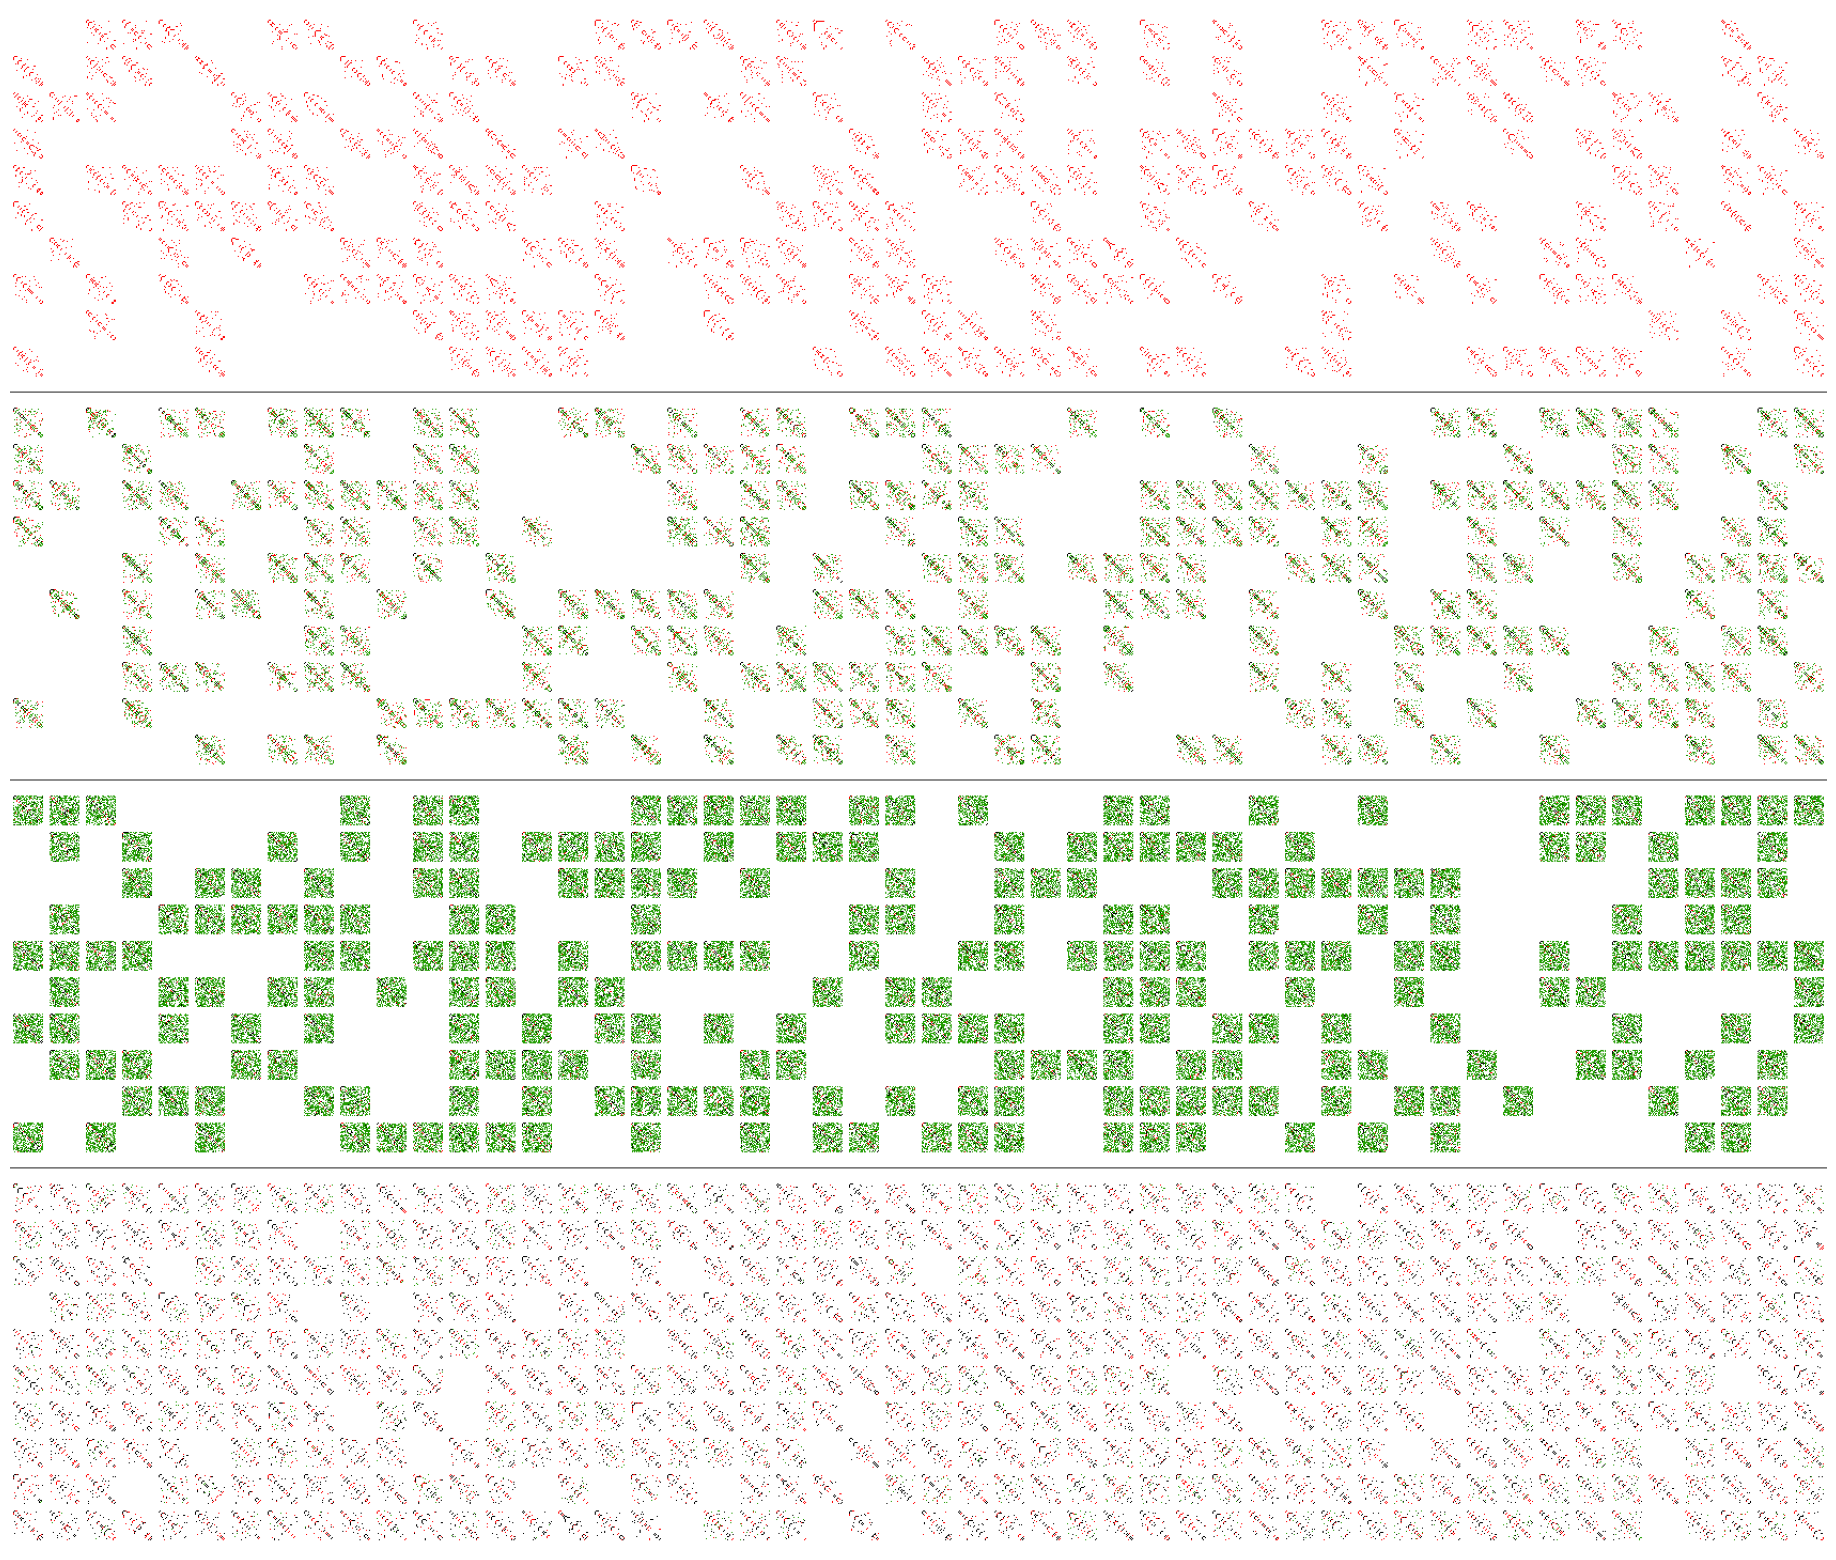

In [8]:
import networkx as nx
import numpy as np
import random, math
from PIL import Image
import os
from collections import defaultdict
import jsonpickle

import matplotlib.pyplot as plt

#

prefixs=['cf2','clear','countergan','graph_countergan']#'countergan',

methods = {}
for file in os.listdir(src_dir):
    for i,prefix in enumerate(prefixs):
        methods.setdefault(prefix,[]) 
        if file.startswith(prefix):
            model_dir = os.path.join(src_dir,file)
            for fold in os.listdir(model_dir):
                methods[prefix].append(os.path.join(model_dir,fold))

        #    if os.path.exists(model_file_name):

#nrow=ncol= int(math.sqrt(ds_size))

######### AUTISM ########
src_dir='/NFSHOME/mprado/CODE/gretel-steel-2/GRETEL/output/dump/InstancesDumper/autism_dataset'

nrow=10
ncol=10

n=116
img_pad=3
factor = 5
exp_pad=int(n/5)
res_boost=3

direction="v"

######### TC ########
src_dir='/NFSHOME/mprado/CODE/gretel-steel-2/GRETEL/output/dump/InstancesDumper/TC28'
nrow=10
ncol=50

n=28
img_pad=3
factor = 2
exp_pad=int(n/5)
res_boost=2

direction="v"

######
'''info = {
            "orginal_id":instance_1.id,
            "correctness":correctness,
             "fold": explainer.fold_id,
            "orginal":instance_1.to_numpy_array(),
            "counterfactual": instance_2.to_numpy_array()
        }'''
if direction == 'v':
    plt.rc('figure', figsize=(len(prefixs)*ncol*res_boost,nrow*res_boost))
else:
    plt.rc('figure', figsize=(nrow*res_boost,len(prefixs)*ncol*res_boost))
    
my_img = None
for m,prefix in enumerate(prefixs):
    folds = methods[prefix]
    exp_img = None
    my_row = None 
    for row,fold in enumerate(folds):      
        for c,file in enumerate(os.listdir(fold)):
            with open(os.path.join(fold,file),'r') as info_file:
                info = jsonpickle.decode(info_file.read())
                
                factual = (info["orginal"]).astype(np.int16)
                counterfactual = (info['counterfactual']).astype(np.int16)
                counterfactual[counterfactual > 1] = 1
                add_edg_rem = (counterfactual-factual)*2+factual

                if not int(info["correctness"]): # here you need to check the Correctness
                    add_edg_rem = np.zeros((n,n),np.int16)
                    #rotated_array = np.flip(np.eye(n,dtype=np.int16),axis=1) #rotate the array 180 degrees
                    #add_edg_rem = np.eye(n,dtype=np.int16)+rotated_array

                #rgb(124,252,0) darker green
                r = np.copy(add_edg_rem)
                r[r == 0] = 255
                r[r == 1] = 0
                r[r == 2] = 32
                r[r ==-1] = 255
                r = np.pad(r, pad_width=((img_pad, img_pad), (img_pad, img_pad)),constant_values=255)
                
                g = np.copy(add_edg_rem)
                g[g == 0] = 255
                g[g == 1] = 0
                g[g == 2] = 156
                g[g ==-1] = 0
                g = np.pad(g, pad_width=((img_pad, img_pad), (img_pad, img_pad)),constant_values=255)

                b = np.copy(add_edg_rem)
                b[b == 0] = 255
                b[b == 1] = 0
                b[b == 2] = 0
                b[b ==-1] = 0
                b = np.pad(b, pad_width=((img_pad, img_pad), (img_pad, img_pad)),constant_values=255)
                img = np.stack([r,g,b],axis=2)

                if my_row is None:
                    my_row=img
                elif(c < ncol):
                    my_row = np.concatenate((my_row,img), axis=1)
                else:
                    break

        if exp_img is None:                
            exp_img=my_row
        else:
            exp_img = np.concatenate((exp_img,my_row), axis=0)
            
        my_row = None

        if(row >= nrow-1): 
            break

    exp_img = np.pad(exp_img, pad_width=((img_pad*factor, img_pad*factor), (0, 0),(0,0)),constant_values=255)

    if(m < len(prefixs)-1):
        if direction == "h":
            exp_img = np.pad(exp_img, pad_width=((0, 0), (0, exp_pad),(0,0)),constant_values=255)
            exp_img = np.pad(exp_img, pad_width=((0, 0), (0, int(exp_pad/4)),(0,0)),constant_values=50)
            exp_img = np.pad(exp_img, pad_width=((0, 0), (0, exp_pad),(0,0)),constant_values=255)
        else:
            exp_img = np.pad(exp_img, pad_width=((0, exp_pad),(0, 0), (0,0)),constant_values=255)
            exp_img = np.pad(exp_img, pad_width=((0, int(exp_pad/4)),(0, 0) ,(0,0)),constant_values=50)
            exp_img = np.pad(exp_img, pad_width=((0, exp_pad), (0, 0),(0,0)),constant_values=255)

    if my_img is None:        
        my_img=exp_img
    else:
        if direction == "h":
            my_img = np.concatenate((my_img,exp_img), axis=1)
        else:
            my_img = np.concatenate((my_img,exp_img), axis=0)#

if my_img is not None:
    imgplot = plt.imshow(my_img)
    plt.axis('off')
    #plt.savefig('./RSGG_ASD_zoom.svg', bbox_inches='tight')
    plt.savefig('./ALL_TC.svg', bbox_inches='tight')
    plt.show()